this notebook serves as validation of the 'group GLM' class for parallel fitting of models. 

In [15]:
import tensorflow as tf
import numpy as np
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sess = tf.Session()

In [83]:
from glm_utils import *

num_neurons = 10
num_features = 50
T = 100000

design_mat = np.zeros([T, num_features, num_neurons])
weight_mat = np.zeros([num_features, num_neurons])
weight_inits = np.zeros_like(weight_mat)
y = np.zeros([T, num_neurons])

for i in range(num_neurons):
    s, w, t = generate_data(T, num_features, filt_amp = np.random.randint(2, 20), noise_model='exponential', non_lin = sigmoid)
    
    design_mat[:, :, i] = s
    weight_mat[:, i] = w
    weight_inits[:, i] = np.linalg.pinv(s).dot(t)
    
    y[:, i] = t

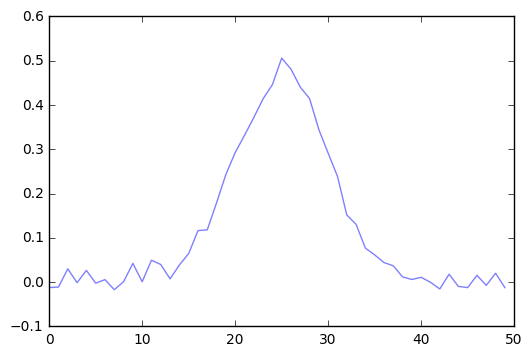

In [61]:
plt.plot(weight_inits[:, 7], alpha = .5);

In [42]:
#test for the easy case, gaussian GLM

non_lin, lr = tf.sigmoid, 0.005

design = tf.placeholder('float32', [None, num_features * num_neurons])
obs_ = tf.placeholder('float32', [None, num_neurons])

weights = tf.Variable(weight_inits.reshape([num_neurons*num_features]), dtype = 'float32', name ='OGweights')

offset = tf.Variable(0.0, dtype = 'float32', trainable = True)
scale = tf.Variable(1.0, dtype = 'float32', trainable = True)


fx = tf.mul(design, weights)
fx = tf.reshape(fx, [-1, num_features, num_neurons])

fx = tf.reduce_sum(fx, reduction_indices = [1]) - offset

lam = non_lin(fx) 
lam_ = tf.mul(scale,lam)

loss = tf.reduce_sum(tf.pow(obs_ - lam_, 2), reduction_indices = [0])

optimizer = tf.train.AdamOptimizer(lr)
gvs = optimizer.compute_gradients(loss)
#capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
#train_step = optimizer.apply_gradients(gvs)

train_step =  tf.train.AdamOptimizer(lr).minimize(loss)
sess.run(tf.initialize_all_variables())

In [46]:
loss

<tf.Tensor 'Sum_32:0' shape=(10,) dtype=float32>

In [47]:
import pyprind

loss_arr = []

bar = pyprind.ProgBar(200, bar_char='*')

for i in range(200):

    bar.update()
    l, _ = sess.run([loss, train_step], feed_dict = {design:design_mat.reshape(-1, num_neurons*num_features), obs_: y})

    loss_arr.append(l[0])    

0%                          100%
[                              ]

InternalError: Dst tensor is not initialized.
	 [[Node: _recv_Placeholder_22_0/_14 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_273__recv_Placeholder_22_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: Sum_32/_16 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_81_Sum_32", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

In [94]:
import group_glm as gm

model = gm.exponential_GLM(weight_inits.reshape([num_neurons, num_features]), non_lin = tf.nn.sigmoid, alpha = 0, 
                        train_params = True, lr = 1e-2)


L, l = model.fit(design_mat.reshape(-1, num_neurons*num_features),y)

0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:00:02


(500, 10)


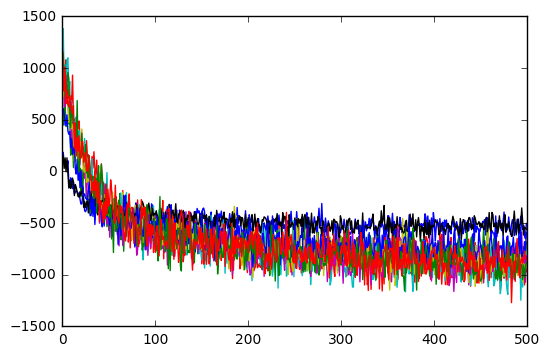

In [96]:
L = np.array(L)

print L.shape

plt.plot(L);

In [97]:
w, o, c = model.get_params()

In [98]:
w = w.reshape(num_features, num_neurons)

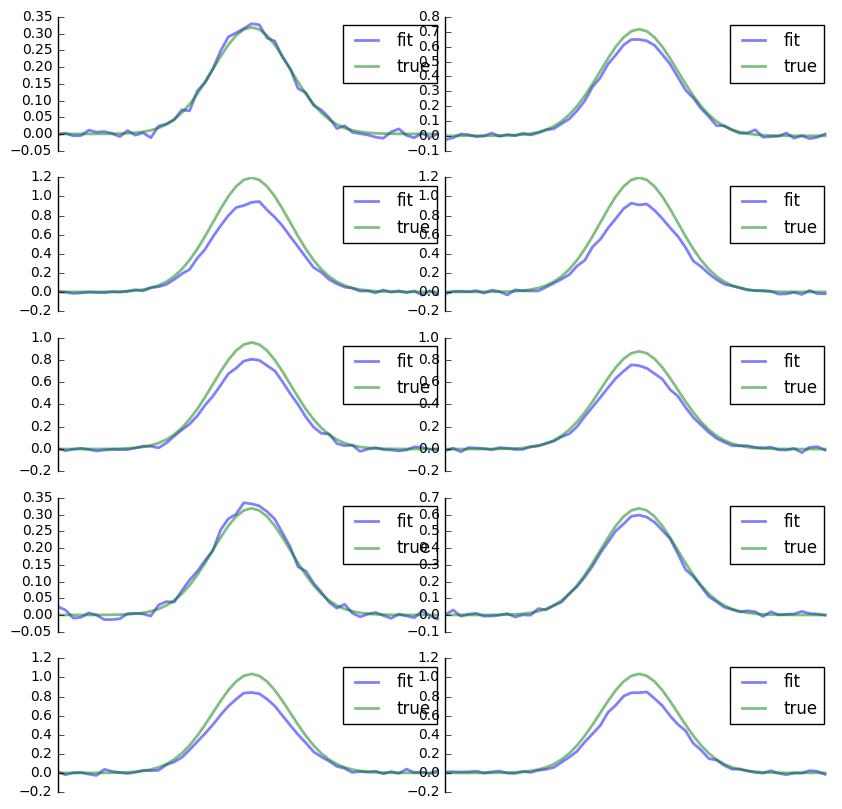

In [99]:
num_rows, num_cols = 5, 2


plt.figure(figsize = [10, 10])
gs, ax = gridplot(num_rows, num_cols)

for i, axes in enumerate(ax):
    axes.plot(w[:, i], c = 'b', linewidth = 2, alpha = .5, label = 'fit')
    axes.plot(weight_mat[:, i], c = 'g', linewidth = 2, alpha = .5, label = 'true')
    axes.legend()
    simpleaxis(axes)